Packanges to install and import

In [18]:
RUN_SETUP = False

if RUN_SETUP:
    !pip install vaderSentiment
    !pip install praw
    !pip install networkx
    !pip install matplotlib
    !pip install numpy
    !pip install python-louvain
    !pip install seaborn
    !pip install pandas
    !pip install fa2
    !pip install scikit-learn
    !pip install nltk
    !pip install scipy
    !pip install fa2_modified

In [19]:
import praw, json, os, re, pickle, hashlib, time
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community as community_louvain
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA
import seaborn as sns
sns.set(style="whitegrid")
from IPython.display import display, Markdown
from collections import Counter
from fa2_modified import ForceAtlas2
from matplotlib import cm
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import defaultdict
from scipy.stats import ttest_1samp
import nltk
nltk.download(['wordnet', 'omw-1.4', 'vader_lexicon'])
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\willi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\willi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\willi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Data collection

We want to collect the most popular Reddit threads containing the words "Harris" or "Trump" and their comments from three days before to three days after the 2024 US election.

We will use Reddit's API for data collection with the PRAW library. The raw data is stored in two JSON files, threads.json and comments.json, in the folder project-data.

*Data storing configuration*

We store files in /project-data.

In [20]:
directory = 'project-data'

files = {
    'threads.json',
    'comments.json',
}

os.makedirs(directory, exist_ok=True)

# we initialize empty JSON files if they don't exist
for file in files:
    file_path = os.path.join(directory, file)
    if not os.path.exists(file_path):
        with open(file_path, 'w') as f:
            # Write an empty list
            f.write('[]')

# we define the attributes we want to extract from the Reddit API
thread_attributes = [
    'id',                # Unique identifier for the thread
    'title',             # Title of the thread
    'selftext',          # Text content of the thread (if it’s a text post)
    'score',             # Upvote score of the thread
    'upvote_ratio',      # Ratio of upvotes to total votes
    'author',            # Username of the author
    'subreddit',         # Subreddit where the thread was posted
    'num_comments',      # Number of comments on the thread
    'created_utc',       # UTC timestamp of the thread's creation
    'created_pretty',    # Human-readable timestamp of the thread's creation
    'permalink',         # Relative URL path to the thread
    'url',               # External link if it’s a link post
    'domain'             # Domain of the link if it’s a link post
]

comment_attributes = [
    'id',                # Unique identifier for the comment
    'parent_id',         # ID of the parent comment or thread
    'body',              # Text content of the comment
    'author',            # Username of the commenter
    #'is_submitter',     # Whether the author is the original poster of the submission
    'subreddit',         # Subreddit where the comment was posted
    'thread_id',
    #'link_id',          # ID of the associated submission
    #'score',            # Upvote score of the comment
    'created_utc',       # UTC timestamp of the comment's creation
    #'depth',            # Depth level in the comment tree
    #'permalink',        # URL path to the comment for reference
    #'edited',           # Boolean indicating if the comment was edited
    #'controversiality'  # Indicator of controversiality (0 or 1)
]

# we initialize the Reddit instance
reddit = praw.Reddit(
    client_id='iZimPVWP4rJpaznU5p_nfQ',
    client_secret='RAvY2FCgjzu-BaQgw1dExy3Y5e98FA',
    user_agent='python:sentiment_analysis_script:v1.0 (by /u/Alternative-Cap)'
)

Throughout the Jupyter file, we will store the computed data in Pickle files to avoid re-computation. Therefore, we define two helper functions to load and save objects, using a hash ID to indicate whether the object is outdated.

In [21]:
def load_cached_data(list, pickle_file):
    hash = hashlib.md5(str(list).encode()).hexdigest()
    try:
        with open(pickle_file, "rb") as f:
            data = pickle.load(f)
            if data.get("hash") == hash:
                print("Using cached data.")
                return data["data"]
    except FileNotFoundError:
        pass
    return None 

def save_cached_data(list, data, pickle_file):
    hash = hashlib.md5(str(list).encode()).hexdigest()
    with open(pickle_file, "wb") as f:
        pickle.dump({"hash": hash, "data": data}, f)
        print("Cached data saved.")

We define three helper functions to load, insert, and update objects in the JSON files.

In [22]:
def get_data(file):
    file_path = os.path.join(directory, file)
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
        except json.JSONDecodeError:
            print(f"Error: {file} is corrupted. Skipping operation.")
            return None
    else:
        print(f"Error: {file} not found. Skipping operation.")
        return None
    return data

def insert_data(batch_data, file, unique_id_attr, attributes_to_store):
    file_path = os.path.join(directory, file)
    
    existing_data = get_data(file)
    if existing_data is None:
        return

    # we extract existing IDs directly from the file
    existing_ids = {item[unique_id_attr] for item in existing_data}

    new_entries = []
    for data in batch_data:
        # we only insert if the unique ID is new
        if data[unique_id_attr] not in existing_ids:
            filtered_data = {}
            for attr in attributes_to_store:
                value = data.get(attr)
                # we convert non-serializable objects
                if attr == 'author' and value is not None:
                    filtered_data[attr] = value.name
                elif attr == 'subreddit' and value is not None:
                    if isinstance(value, str):
                        filtered_data[attr] = value
                    else:
                        filtered_data[attr] = value.display_name
                else:
                    filtered_data[attr] = value
                    
            # we add to new entries and update existing IDs set
            new_entries.append(filtered_data)
            existing_ids.add(data[unique_id_attr])

    # we append all new entries to existing data
    if new_entries:
        existing_data.extend(new_entries)

        # we save the updated data back to the main file using a temporary file
        temp_file_path = file_path + '.temp'
        with open(temp_file_path, 'w') as f:
            json.dump(existing_data, f, indent=4)

        # we replace the original file with the temporary file if no errors occur
        os.replace(temp_file_path, file_path)
        
    print(f"Inserted {len(new_entries)} new entries.")
    
def update_field(file, unique_id_attr, id_value, field, value):
    file_path = os.path.join(directory, file)
    
    existing_data = get_data(file)
    if existing_data is None:
        return

    # we find and update the specified field for the matching entry
    for entry in existing_data:
        if entry.get(unique_id_attr) == id_value:
            entry[field] = value
            break

    # we save the updated data back to the main file using a temporary file
    temp_file_path = file_path + '.temp'
    with open(temp_file_path, 'w') as f:
        json.dump(existing_data, f, indent=4)

    # we replace the original file with the temporary file if no errors occur
    os.replace(temp_file_path, file_path)
    
    print(f"Updated {field} for {unique_id_attr} {id_value} to {value}.")

To ensure the threads are relevant to the analysis, we will only include threads with the words "Harris" or "Trump" in the title or description.

In [23]:
def contains_candidates_names(thread_data, names=['trump', 'harris']):
    # we combine names into a regex pattern to match full words
    pattern = r'\b(' + '|'.join(re.escape(name) for name in names) + r')\b'
    
    # we search in the title and selftext of the thread
    content = (thread_data.get('title', '') + " " + thread_data.get('selftext', '')).lower()
    
    # return true if any of the names are found
    return bool(re.search(pattern, content))

We define the target timeframe as three days before and three days after the 2024 U.S. election.

In [24]:
election_date = datetime(2024, 11, 5)
start_date = election_date - timedelta(days=3) # November 2, 2024
end_date = election_date + timedelta(days=3) # November 8, 2024

We define the subreddits from which to collect threads. I have tried to include some for general news and politics, some that are biased (such as 'Conservative' and 'Liberal'), and news media with different political views.

In [25]:
subreddits = [
    'politics',           # General politics subreddit (liberal-leaning news)
    'news',               # General news subreddit
    'worldnews',          # International news
    'Conservative',       # Conservative viewpoints
    'Liberal',            # Liberal viewpoints
    'nytimes',            # *The New York Times*
    'npr',                # *National Public Radio*
    'FoxNews',            # *Fox News*
    'MSNBC',              # *MSNBC*
    'cnn',                # *CNN*, generally center-left
]

We create a helper function to display markdown tables.

In [26]:
def create_table_markdown(headers, rows, table_title=""):
    markdown_table = "| " + " | ".join(headers) + " |\n"
    markdown_table += "| " + " | ".join(["-" * len(col) for col in headers]) + " |\n"
    for row in rows:
        markdown_table += "| " + " | ".join(str(item) for item in row) + " |\n"
    display(Markdown(f"### {table_title}\n" + markdown_table))

We visualize the contributions of relevant threads from each subreddit.

Using cached data.


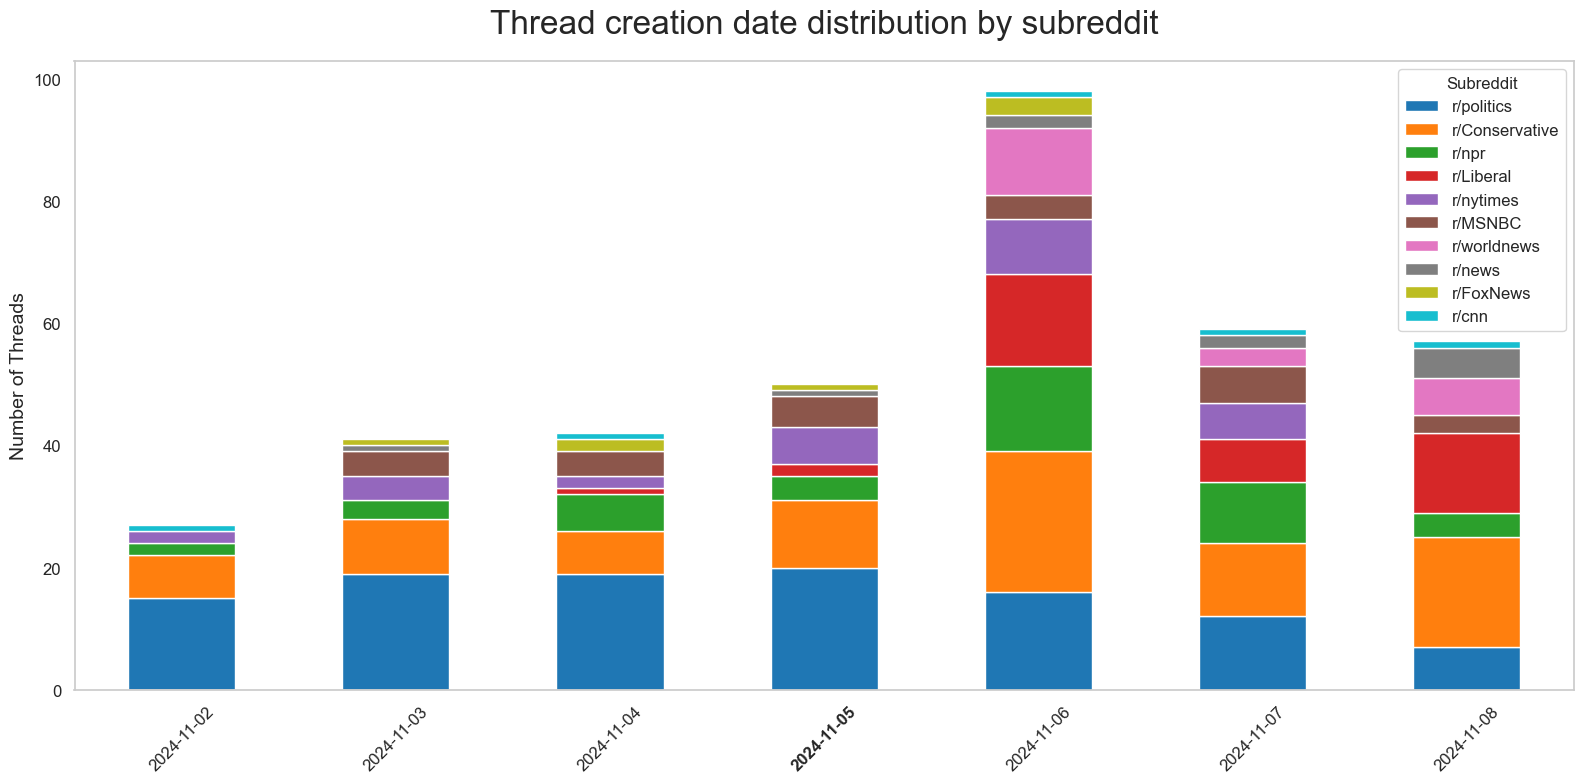

In [27]:
def get_subreddit_dates(subreddits, start_date, end_date):
    pickle_file = os.path.join(directory, "subreddit_dates_data.pkl")
    count_data = load_cached_data(subreddits, pickle_file)
    if count_data is not None:
        return count_data

    subreddit_dates = {}
    for subreddit_name in subreddits:
        subreddit = reddit.subreddit(subreddit_name)
        dates = []
        
        for submission in subreddit.top('month', limit=500):
            created_date = datetime.utcfromtimestamp(submission.created_utc).date()
            if start_date.date() <= created_date <= end_date.date():
                thread_data = vars(submission).copy()
                if contains_candidates_names(thread_data):
                    dates.append(created_date)
        
        subreddit_dates[subreddit_name] = dates

    data_df = pd.DataFrame([(date, subreddit) for subreddit, dates in subreddit_dates.items() for date in dates],
                           columns=['Date', 'Subreddit'])
    count_data = data_df.groupby(['Date', 'Subreddit']).size().unstack(fill_value=0)

    save_cached_data(subreddits, count_data, pickle_file)    
    return count_data

count_data = get_subreddit_dates(subreddits, start_date, end_date)
count_data = count_data[count_data.sum().sort_values(ascending=False).index]
ax = count_data.plot(kind='bar', stacked=True, figsize=(16, 8), color=sns.color_palette("tab10", 10))
ax.legend([f"r/{label}" for label in count_data.columns], title="Subreddit", fontsize=12, title_fontsize=12)
plt.title("Thread creation date distribution by subreddit", fontsize=24, pad=20)
plt.xlabel("")
plt.grid(False)
plt.ylabel("Number of Threads", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
if len(count_data.index) >= 4:
    ax.get_xticklabels()[3].set_fontweight("bold")
plt.tight_layout()
plt.show()

del count_data

We see that we have good coverage with relevant threads for the selected days. There is a peak in threads on the 6th of November, the day after the election, and the day the result was announced. We also see that the largest contributing subreddit is "politics" and that all ten subreddits contribute some threads.

We collect all the threads within the relevant timeframe.

In [28]:
def get_threads(subreddits, start_date, end_date):
    pickle_file = os.path.join(directory, "threads_data.pkl")
    threads = load_cached_data(subreddits, pickle_file)
    if threads is not None:
        return threads

    # if no cache, retrieve data from Reddit
    threads = []
    for subreddit_name in subreddits:
        subreddit = reddit.subreddit(subreddit_name)
        
        for submission in subreddit.top('month', limit=1000):
            created_date = datetime.utcfromtimestamp(submission.created_utc).date()
            if start_date.date() <= created_date <= end_date.date():
                thread_data = vars(submission).copy()
                thread_data['created_pretty'] = created_date.strftime('%Y-%m-%d %H:%M:%S UTC')
                thread_data['subreddit'] = subreddit_name
                threads.append(thread_data)
    
    # cache the results
    save_cached_data(subreddits, threads, pickle_file)
    return threads

threads = get_threads(subreddits, start_date, end_date)

Using cached data.


We store all the relevant threads in a JSON file.

In [29]:
batch_data = []
for thread in threads:
    if contains_candidates_names(thread):
        batch_data.append(thread)

insert_data(batch_data, 'threads.json', 'id', thread_attributes)

del threads, batch_data

Inserted 0 new entries.


We collect all the comments and, for each comment, we store the comment ID, parent ID (the ID of the comment it replies to), body (message), author (username), subreddit, thread ID, and created_utc (timestamp).

Example:

```json
{
  "id": "lvj632v",
  "parent_id": "t3_1gk7qtd",
  "body": "There's another poll going on right now - it's called Voting Day, go participate.",
  "author": "Gymrat777",
  "subreddit": "politics",
  "thread_id": "1gk7qtd",
  "created_utc": 1730819352.0
}


In [30]:
class SubredditMock:
    def __init__(self, display_name):
        self.display_name = display_name

In [31]:
threads = get_data('threads.json')
if threads is None:
    print("Error loading threads.json.")
else:
    threads_to_process = [thread for thread in threads if not thread.get('comments_retrieved', False)][:50]
    i = 0
    for thread in threads_to_process:
        submission = reddit.submission(id=thread['id'])
        submission.comments.replace_more(limit=1000)

        comments = []
        authors_in_thread = set()
        for comment in submission.comments.list():
            author = comment.author

            # we skip if author is None, AutoModerator or already added for this thread
            if author is None or author.name in authors_in_thread:
                continue
            
            if author.name == 'AutoModerator':
                continue
            
            comment_data = {
                'id': comment.id,
                'parent_id': comment.parent_id,
                'body': comment.body[:500],
                'author': comment.author,
                'is_submitter': comment.is_submitter,
                'subreddit': SubredditMock(comment.subreddit.display_name),
                'link_id': comment.link_id,
                'score': comment.score,
                'created_utc': comment.created_utc,
                'depth': comment.depth,
                'permalink': comment.permalink,
                'edited': comment.edited,
                'controversiality': comment.controversiality,
                'thread_id': thread['id']
            }
            comments.append(comment_data)
            authors_in_thread.add(author.name)
        i = i + 1
        print(f"Processed {i} threads.")
        update_field('threads.json', 'id', thread['id'], 'comments_retrieved', True)
        insert_data(comments, 'comments.json', 'id', comment_attributes)

del threads

## 2. Undirected graph

We create an undirected graph where each user is represented as a node, and the edges represent a reply to a comment. I choose an undirected graph to focus simply on user interaction. We extract and focus only on the largest component.

Example: 

![Example](./project-data/graph.png)

In [32]:
def create_or_load_graph(comments_data):
    pickle_file = os.path.join(directory, "graph.pkl")
    
    # we use chaching for fast notebook execution
    cached_graph = load_cached_data([len(comments_data)], pickle_file)

    if cached_graph is not None:
        return cached_graph
    
    G = nx.Graph()
    
    # we create a dictionary to map comment IDs to authors (for faster lookup)
    id_to_author = {comment['id']: comment['author'] for comment in comments_data}

    for comment in comments_data:
        author = comment['author']
        if not author:
            continue
        
        # we add the author as a node in the graph, as networkx will automatically ignore duplicates
        G.add_node(author)
        
        # we check if this comment is a reply to another comment (and not the thread itself)
        parent_id = comment['parent_id']
        if parent_id.startswith("t1_"):
            
            # we extract the ID of the parent comment (removing "t1_" prefix)
            parent_comment_id = parent_id[3:]
            
            # we lookup the author of the parent comment using the dictionary
            parent_author = id_to_author.get(parent_comment_id)
            
            # we add an edge if the parent author exists and is different from the current author
            if parent_author and parent_author != author:
                G.add_edge(author, parent_author)
    
    # remove nodes with zero degree
    G.remove_nodes_from([node for node, degree in dict(G.degree()).items() if degree == 0])
    
    # extract largest connected component
    largest_component = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_component).copy()
    
    # cache the graph data
    save_cached_data([len(comments_data)], G, pickle_file)
    return G

comments_data = get_data('comments.json')
G = create_or_load_graph(comments_data)
print("Number of nodes in the largest component:", G.number_of_nodes())
print("Number of edges in the largest component:", G.number_of_edges())

Using cached data.
Number of nodes in the largest component: 61937
Number of edges in the largest component: 85882


We plot the degree distribution of the graph.

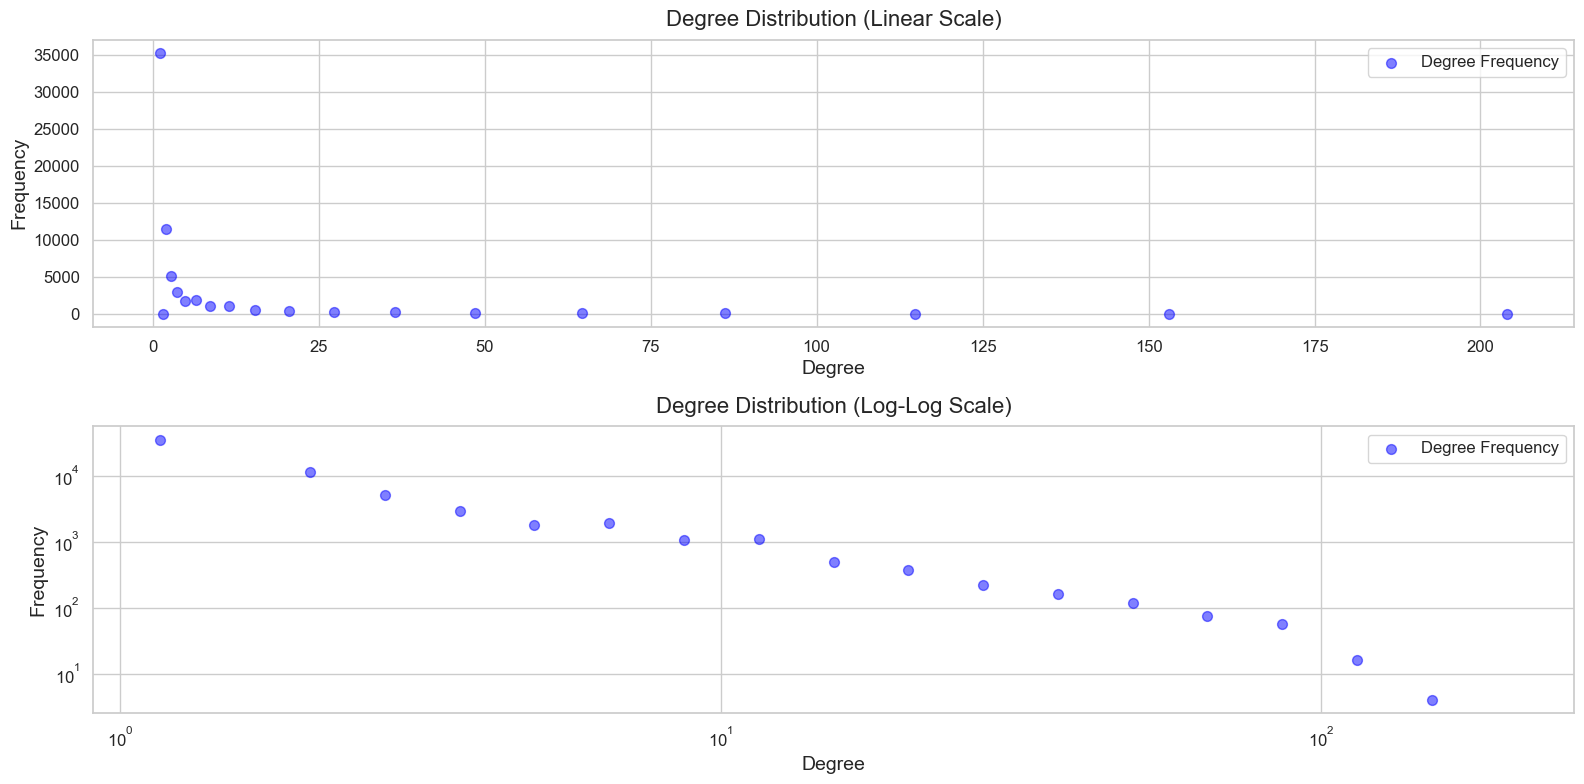

In [33]:
# we calculate the degree sequence
degree_counts = [deg for _, deg in G.degree()]

# bin the degree distribution using logarithmic spacing
histogram, bin_edges = np.histogram(degree_counts, bins=np.logspace(np.log10(min(degree_counts)), np.log10(max(degree_counts)), 20))

# we calculate the center of each bin for accurate plotting
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

sns.set(style="whitegrid")

plt.figure(figsize=(16, 8))

# linear scale plot
plt.subplot(2, 1, 1)
plt.scatter(bin_centers, histogram, color='blue', alpha=0.5, s=50, label='Degree Frequency')
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Degree', fontsize=14)
plt.title('Degree Distribution (Linear Scale)', fontsize=16, pad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

# log-log scale plot
plt.subplot(2, 1, 2)
plt.scatter(bin_centers, histogram, color='blue', alpha=0.5, s=50, label='Degree Frequency')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Degree', fontsize=14)
plt.title('Degree Distribution (Log-Log Scale)', fontsize=16, pad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


We see that the degree distribution is linear on a log-log scale, resembling a power-law distribution of a scale-free network, where few nodes have a very large degree and many nodes have a low degree.

## 3. Communities

We use the Louvain method to find good partitions with high modularity. We test different resolutions between 0 and 1 to find the resolution that gives large communities.

In [34]:
pickle_file = os.path.join(directory, "resolution_test.pkl")
resolutions = [0.1 * i for i in range(1, 11)]
resolutions_results = load_cached_data(resolutions, pickle_file)

if not resolutions_results:
    resolutions_results = []
    for resolution in resolutions:
        partition = community_louvain.best_partition(G, resolution=resolution)
        modularity = round(community_louvain.modularity(partition, G), 3)
        community_sizes = Counter(partition.values())
        largest_communities = sorted(community_sizes.values(), reverse=True)[:5]
        top_sum = round(sum(largest_communities), 3)
        largest_communities = [round(size, 3) for size in largest_communities]
        resolutions_results.append((resolution, modularity, top_sum, largest_communities))
    save_cached_data(resolutions, resolutions_results, pickle_file)
headers = ["Resolution", "Modularity", "Sum of Top 5 Communities", "Top 5 Community Sizes"]
rows = [(round(res,1), mod, top_sum, top_sizes) for res, mod, top_sum, top_sizes in resolutions_results]
create_table_markdown(headers, rows, table_title="Resolution results")

Using cached data.


### Resolution results
| Resolution | Modularity | Sum of Top 5 Communities | Top 5 Community Sizes |
| ---------- | ---------- | ------------------------ | --------------------- |
| 0.1 | 0.703 | 2843 | [2020, 284, 214, 171, 154] |
| 0.2 | 0.706 | 5350 | [3784, 643, 494, 221, 208] |
| 0.3 | 0.665 | 2168 | [1688, 192, 128, 86, 74] |
| 0.4 | 0.703 | 5232 | [4152, 410, 265, 221, 184] |
| 0.5 | 0.706 | 8656 | [4976, 2634, 582, 247, 217] |
| 0.6 | 0.733 | 15548 | [6177, 2880, 2574, 1967, 1950] |
| 0.7 | 0.737 | 16125 | [5411, 3155, 3151, 2247, 2161] |
| 0.8 | 0.739 | 13225 | [4721, 3532, 2063, 1611, 1298] |
| 0.9 | 0.741 | 13101 | [3106, 2577, 2576, 2444, 2398] |
| 1.0 | 0.739 | 7558 | [2900, 1981, 928, 918, 831] |


We see that the top 5 communities are largest, when we use a resolution around 0.7.

In [35]:
partition_pickle_file = os.path.join(directory, "partitions.pkl")
resolution = 0.6
cached_data = load_cached_data([resolution], partition_pickle_file)

if not cached_data:
    partition = community_louvain.best_partition(G, resolution = resolution)
    modularity = community_louvain.modularity(partition, G)
    save_cached_data([resolution], (partition, modularity), partition_pickle_file)
else:
    partition, modularity = cached_data

print(f"Modularity: {round(modularity, 3)}")
print(f"Number of communities: {len(set(partition.values()))}")

Using cached data.
Modularity: 0.736
Number of communities: 103


In [36]:
community_sizes = Counter(partition.values())
top_5_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:5]
headers = ["Community ID", "Size"]
rows = [(community_id, size) for community_id, size in top_5_communities]
create_table_markdown(headers, rows, table_title="Top 5 Communities")

### Top 5 Communities
| Community ID | Size |
| ------------ | ---- |
| 9 | 6073 |
| 18 | 2286 |
| 59 | 2160 |
| 32 | 2141 |
| 45 | 2041 |


## 4. Sentiment analysis

We use the library VADER-Sentiment-Analysis to analyze the average sentiment across all comments and within the top five communities.

In [37]:
analyzer = SIA()
comments_data = get_data('comments.json')
if comments_data is None:
    comments_data = []

top_5_ids = [community_id for community_id, _ in top_5_communities]
top_5_ids_to_string = ', '.join(str(community_id) for community_id in top_5_ids)
community_sentiments = {}
sentiment_data = []
community_pickle_file = os.path.join(directory, "community_sentiments.pkl")
overall_pickle_file = os.path.join(directory, "overall_sentiments.pkl")

community_sentiments_cached = load_cached_data([top_5_ids_to_string], community_pickle_file)
if not community_sentiments_cached:
    for comment in comments_data:
        author = comment['author']
        if author in partition:
            community_id = partition[author]
            text = comment['body'][:500]
            sentiment_score = analyzer.polarity_scores(text)['compound']
            date = datetime.utcfromtimestamp(comment['created_utc']).date()
            if start_date <= date <= end_date:
                if community_id not in community_sentiments:
                    community_sentiments[community_id] = []
                community_sentiments[community_id].append({'date': date, 'sentiment': sentiment_score})
    save_cached_data([top_5_ids_to_string], community_sentiments, community_pickle_file)
    community_sentiments_cached = community_sentiments

sentiment_data_cached = load_cached_data([top_5_ids_to_string], overall_pickle_file)
if not sentiment_data_cached:
    for comment in comments_data:
        text = comment['body'][:500]
        sentiment_score = analyzer.polarity_scores(text)['compound']
        date = datetime.utcfromtimestamp(comment['created_utc']).date()
        if start_date <= date <= end_date:
            sentiment_data.append({'date': date, 'sentiment': sentiment_score})
    save_cached_data([top_5_ids_to_string], sentiment_data, overall_pickle_file)
    sentiment_data_cached = sentiment_data

df = pd.DataFrame(sentiment_data_cached)
daily_sentiment = df.groupby('date')['sentiment'].mean().reset_index()


Using cached data.
Using cached data.


We visualize the average sentiment for each day and observe that the average sentiment decreases in the days after the election, possibly indicating that the majority of the comments in the selected threads are in favor of Harris, who lost the election.

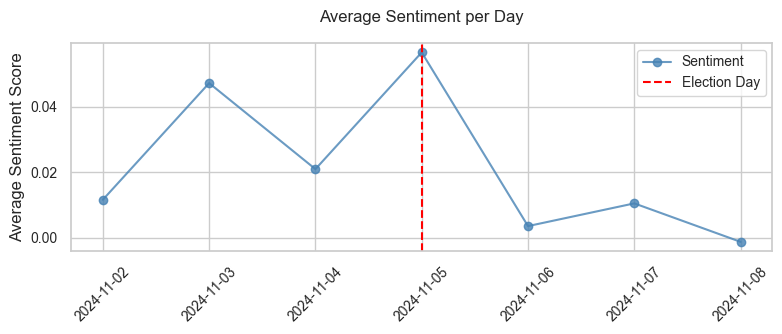

In [38]:
df = pd.DataFrame(sentiment_data_cached)
daily_sentiment = df.groupby('date')['sentiment'].mean().reset_index()

plt.figure(figsize=(8, 3.5))
plt.plot(
    daily_sentiment['date'],
    daily_sentiment['sentiment'],
    marker='o',
    color='steelblue',
    alpha=0.8,
    label="Sentiment",
)
plt.axvline(
    x=election_date,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label="Election Day",
)
plt.title("Average Sentiment per Day", fontsize=12, pad=15)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


We define a color function so that a community gets the same color each time.

In [39]:
def get_community_color(community_index, num_communities):
    colormap = cm.get_cmap('Set2', num_communities)
    return colormap(community_index)

We visualize the change in sentiment for the five communities along with the average sentiment across all comments.

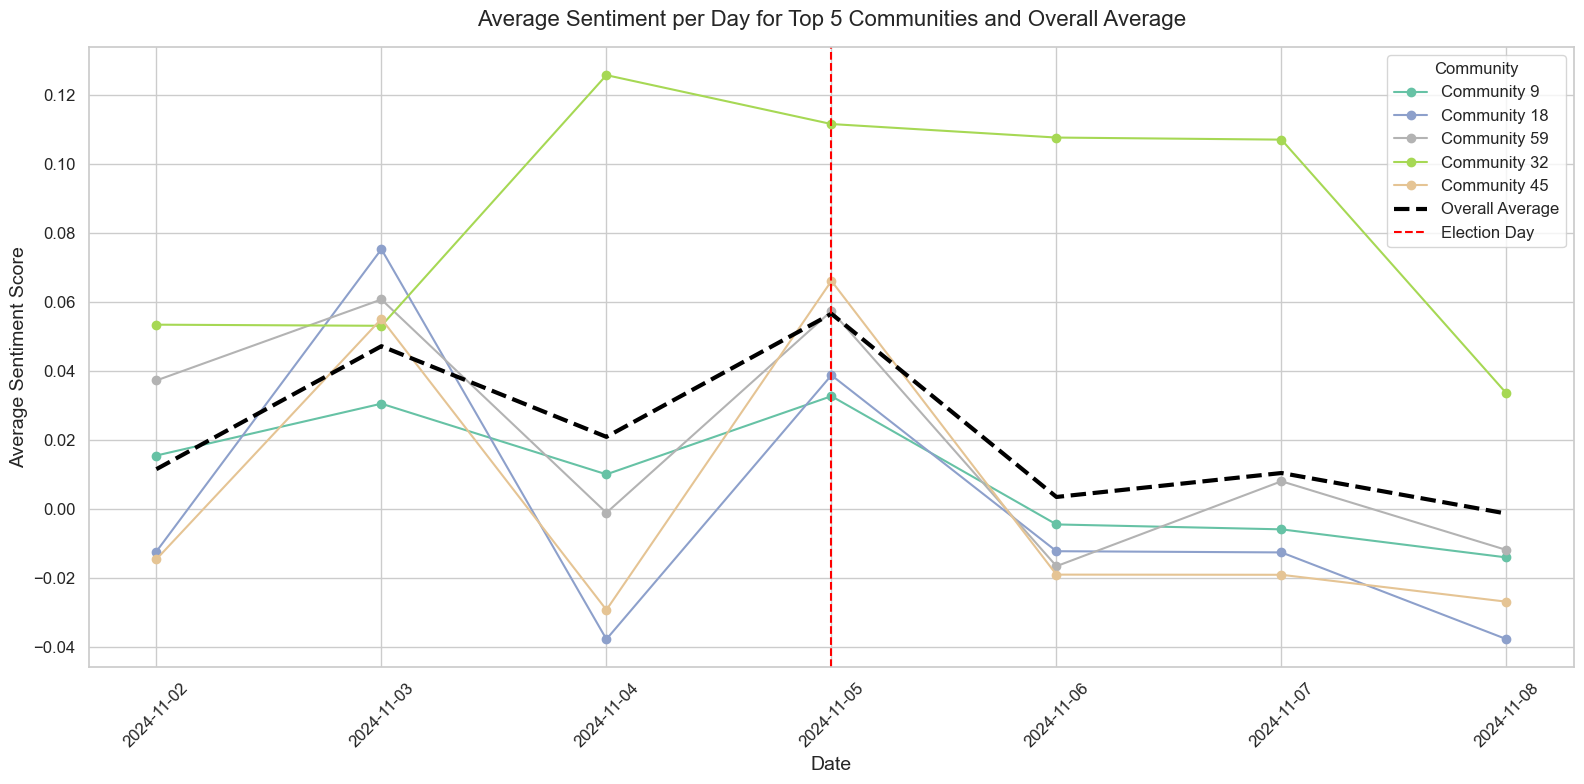

In [40]:
num_communities = len(top_5_communities)
color_map = {community_id: get_community_color(idx, num_communities) for idx, (community_id, _) in enumerate(sorted(top_5_communities), start=0)}
plt.figure(figsize=(16, 8))
for i, (community_id, _) in enumerate(top_5_communities, start=1):
    if community_id in community_sentiments_cached:
        df = pd.DataFrame(community_sentiments_cached[community_id])
        daily_sentiment_community = df.groupby('date')['sentiment'].mean().reset_index()
        community_color = color_map.get(community_id, 'black')
        plt.plot(daily_sentiment_community['date'], daily_sentiment_community['sentiment'], 
                 marker='o', label=f"Community {community_id}", color=community_color)

plt.plot(daily_sentiment['date'], daily_sentiment['sentiment'], color='black', linewidth=3, label="Overall Average", linestyle='--')
plt.axvline(x=election_date, color='red', linestyle='--', linewidth=1.5, label="Election Day")
plt.title("Average Sentiment per Day for Top 5 Communities and Overall Average", fontsize=16, pad=15)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Community", fontsize=12)
plt.tight_layout()
plt.show()

We see that community 32 has the highest sentiment score across all days except 2024-11-03, while the communities 9, 18, 45 and 59 seem to follow the average trend on Reddit.

## 5. Community analysis

We could worry that the communities only represent single threads and the comments within them, so we visualize how the comments are distributed across the threads for each community.

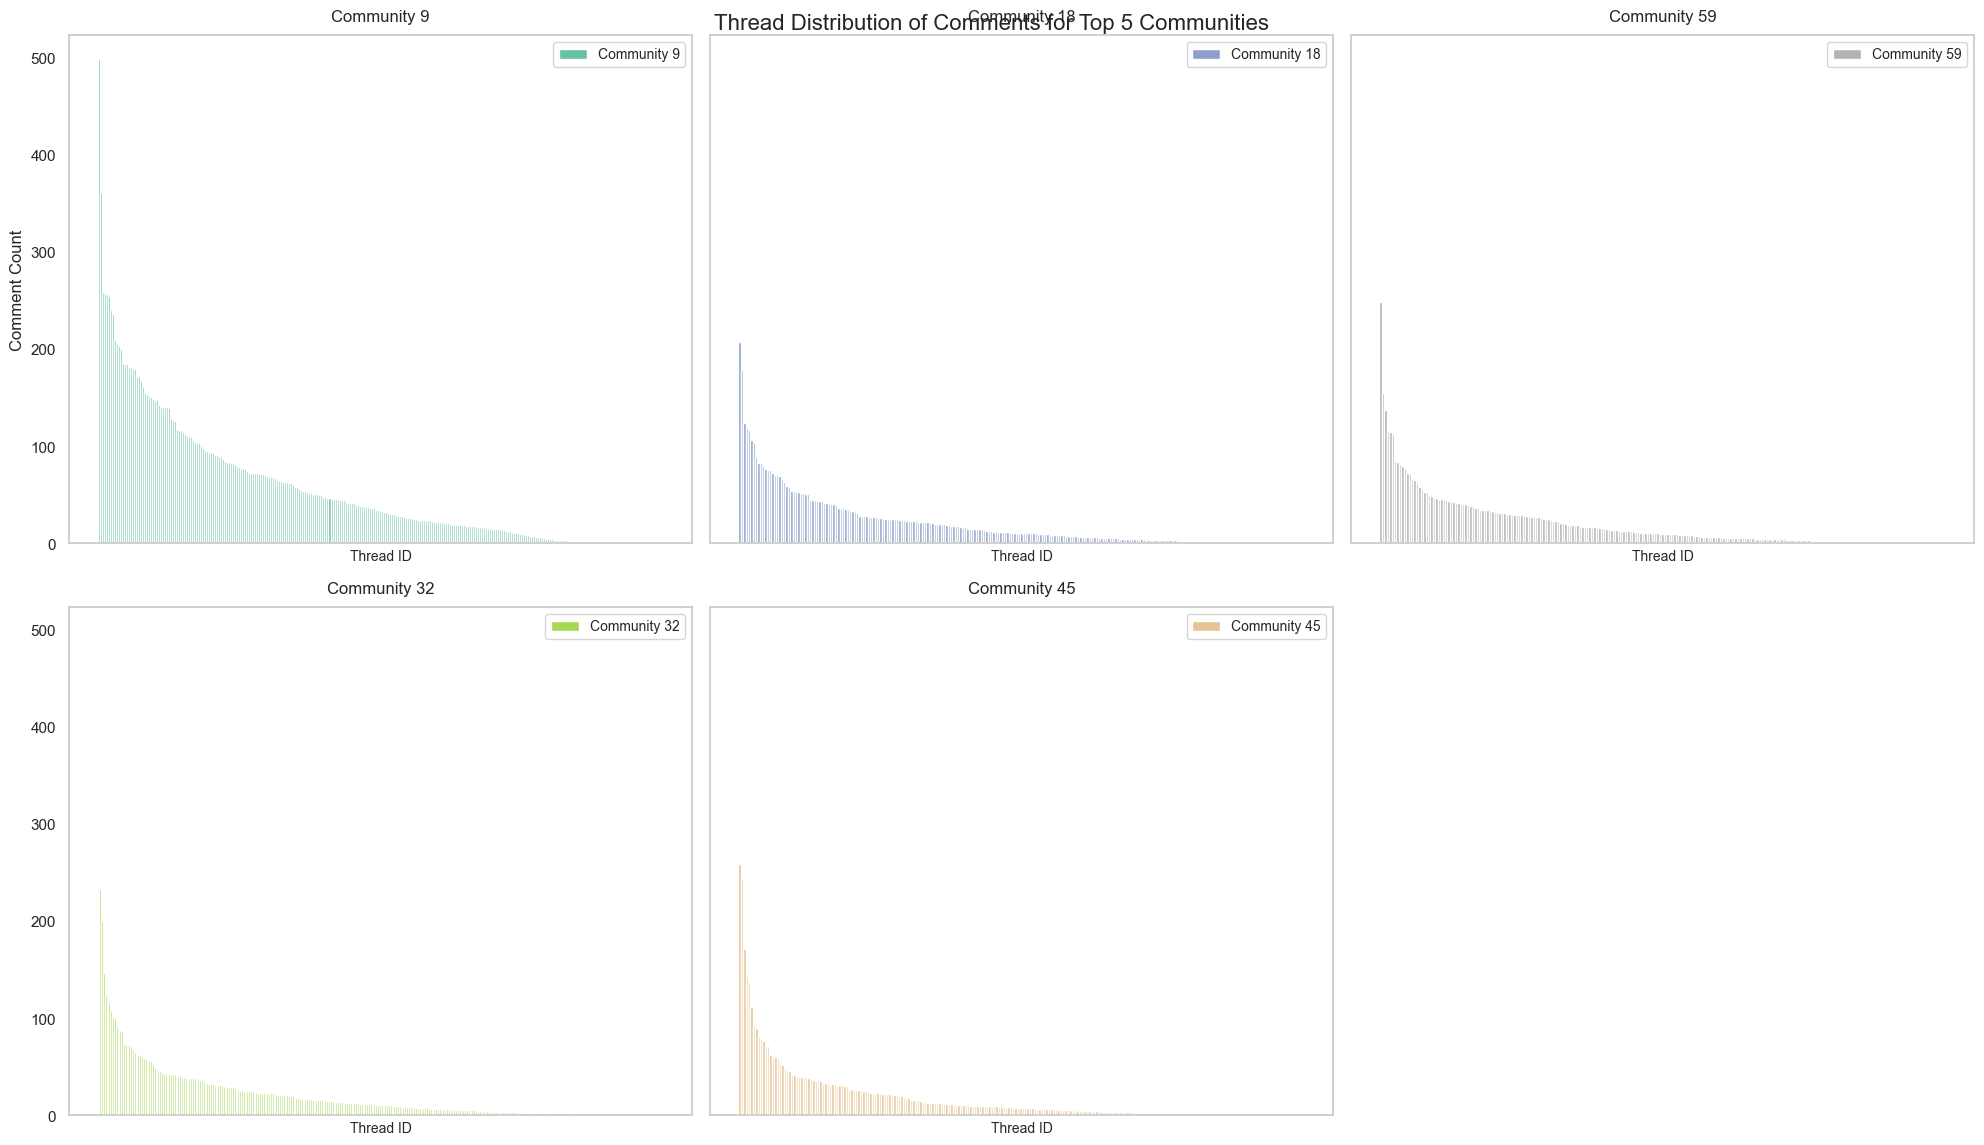

In [41]:
comments_df = pd.DataFrame(comments_data)
comments_df['community_id'] = comments_df['author'].map(partition)
comments_df = comments_df[comments_df['community_id'].notnull()]
comments_df['community_id'] = comments_df['community_id'].astype(int)

top_5_ids = [community_id for community_id, _ in top_5_communities]
top_5_comments_df = comments_df[comments_df['community_id'].isin(top_5_ids)]

fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True)
axes = axes.flatten()
for idx, (ax, community_id) in enumerate(zip(axes, top_5_ids)):
    community_data = (
        comments_df[comments_df['community_id'] == community_id]
        .groupby('thread_id')
        .size()
        .reset_index(name='comment_count')
        .sort_values(by='comment_count', ascending=False)
    )
    
    community_color = color_map.get(community_id, 'gray')
    ax.bar(
        community_data['thread_id'],
        community_data['comment_count'],
        color=community_color,
        width=1,
        label=f'Community {community_id}'
    )
    
    ax.set_title(f"Community {community_id}", fontsize=12, pad=10)
    ax.set_xlabel("Thread ID", fontsize=10)
    ax.set_xticks([])
    ax.legend(fontsize=10)
    ax.grid(False)

for ax in axes[len(top_5_ids):]:
    fig.delaxes(ax)

fig.suptitle("Thread Distribution of Comments for Top 5 Communities", fontsize=16, y=0.95)
axes[0].set_ylabel("Comment Count", fontsize=12)
plt.tight_layout()
plt.show()


We see that while each community's comments are distributed such that a few threads contain many comments and many threads contain fewer comments, overall, it does not appear that each community simply represents a single thread. Instead, the distributions suggest that some threads are more popular than others. I also examined the distributions on a log-log scale, and they were not linear (plot not included).

In [42]:
community_shares = []
for community_id in top_5_ids:
    community_data = (
        comments_df[comments_df['community_id'] == community_id]
        .groupby('thread_id')
        .size()
        .reset_index(name='comment_count')
        .sort_values(by='comment_count', ascending=False)
    )
    total_comments = community_data['comment_count'].sum()
    most_popular_thread_comments = community_data.iloc[0]['comment_count']
    share = most_popular_thread_comments / total_comments * 100
    community_shares.append({
        "Community ID": community_id,
        "Total Comments": total_comments,
        "Most Popular Thread Comments": most_popular_thread_comments,
        "Share (%)": round(share, 2)
    })

community_shares_df = pd.DataFrame(community_shares)
columns = ["Community ID", "Total Comments", "Most Popular Thread Comments", "Share (%)"]
rows = community_shares_df.values.tolist()

table_markdown = create_table_markdown(
    columns,
    rows=rows,
    table_title="Share of Comments in the Most Popular Thread for Top 5 Communities"
)

### Share of Comments in the Most Popular Thread for Top 5 Communities
| Community ID | Total Comments | Most Popular Thread Comments | Share (%) |
| ------------ | -------------- | ---------------------------- | --------- |
| 9.0 | 15992.0 | 498.0 | 3.11 |
| 18.0 | 5183.0 | 207.0 | 3.99 |
| 59.0 | 4823.0 | 248.0 | 5.14 |
| 32.0 | 6791.0 | 360.0 | 5.3 |
| 45.0 | 4464.0 | 259.0 | 5.8 |


Similarly, when we look at the share of comments in the most popular thread, we find that they account for approximately 3 to 6 percent in each community.

In [43]:
conservative_comments = [comment for comment in comments_data if comment['subreddit'] == 'Conservative']
community_comment_counts = Counter()

for comment in conservative_comments:
    author = comment['author']
    if author in partition:
        community_id = partition[author]
        community_comment_counts[community_id] += 1

top_communities = community_comment_counts.most_common()
rows = [(community_id, count) for community_id, count in top_communities[:5]]
create_table_markdown(["Community ID", "Number of Comments"], rows, table_title="Top 5 Communities in 'Conservative'")


### Top 5 Communities in 'Conservative'
| Community ID | Number of Comments |
| ------------ | ------------------ |
| 32 | 5372 |
| 45 | 50 |
| 86 | 44 |
| 39 | 41 |
| 61 | 31 |


We see that Community 32 has the highest number of comments in the subreddit Conservative, which is a right leaning subreddit.

We compute a t-test to determine whether the average sentiment of each of the top five communities significantly differs from the overall average.

In [44]:
overall_sentiments = [entry['sentiment'] for entry in sentiment_data_cached]
overall_average_sentiment = sum(overall_sentiments) / len(overall_sentiments)

# we prepare data for t-test by extracting individual sentiment scores for each community
community_comment_scores = {
    community_id: [entry['sentiment'] for entry in sentiments]
    for community_id, sentiments in community_sentiments_cached.items()
}

# we perform t-tests for each community
t_test_results = []
for community_id, sentiment_scores in community_comment_scores.items():
    if community_id not in top_5_ids:
        continue
    if len(sentiment_scores) < 2:
        t_stat, p_value = float('nan'), float('nan')
    else:
        t_stat, p_value = ttest_1samp(sentiment_scores, overall_average_sentiment)
    
    t_test_results.append({
        'Community': community_id,
        'Average Sentiment': sum(sentiment_scores) / len(sentiment_scores),
        'Number of Comments': len(sentiment_scores),
        't-Statistic': t_stat,
        'p-Value': p_value
    })

t_test_results_df = pd.DataFrame(t_test_results)
t_test_results_df.sort_values(by='Average Sentiment', ascending=False, inplace=True)

rows = [
    [
        result['Community'],
        f"{result['Average Sentiment']:.4f}",
        result['Number of Comments'],
        f"{result['t-Statistic']:.4f}" if not pd.isna(result['t-Statistic']) else "N/A",
        f"{result['p-Value']:.4f}" if not pd.isna(result['p-Value']) else "N/A"
    ]
    for result in t_test_results
]
create_table_markdown(["Community", "Average Sentiment", "Number of Comments", "t-Statistic", "p-Value"], rows, table_title="T-Test results for community sentiments")

### T-Test results for community sentiments
| Community | Average Sentiment | Number of Comments | t-Statistic | p-Value |
| --------- | ----------------- | ------------------ | ----------- | ------- |
| 9 | 0.0079 | 15461 | -1.9753 | 0.0482 |
| 18 | -0.0021 | 5002 | -2.5126 | 0.0120 |
| 32 | 0.0904 | 6504 | 12.2810 | 0.0000 |
| 45 | -0.0088 | 4201 | -3.1646 | 0.0016 |
| 59 | 0.0085 | 4625 | -0.9871 | 0.3236 |


With the null hypothesis that each community has the same average sentiment as the average sentiment for all comments, we see that for $\alpha = 0.05$, Communities 9, 18, 32, and 45 reject the null hypothesis based on the p-value and therefore have an average sentiment that significantly differs from the total average. Only Community 59 does not reject the null hypothesis and therefore has an average sentiment similar to the total average.

We look into how the communities are represented across the subreddits.

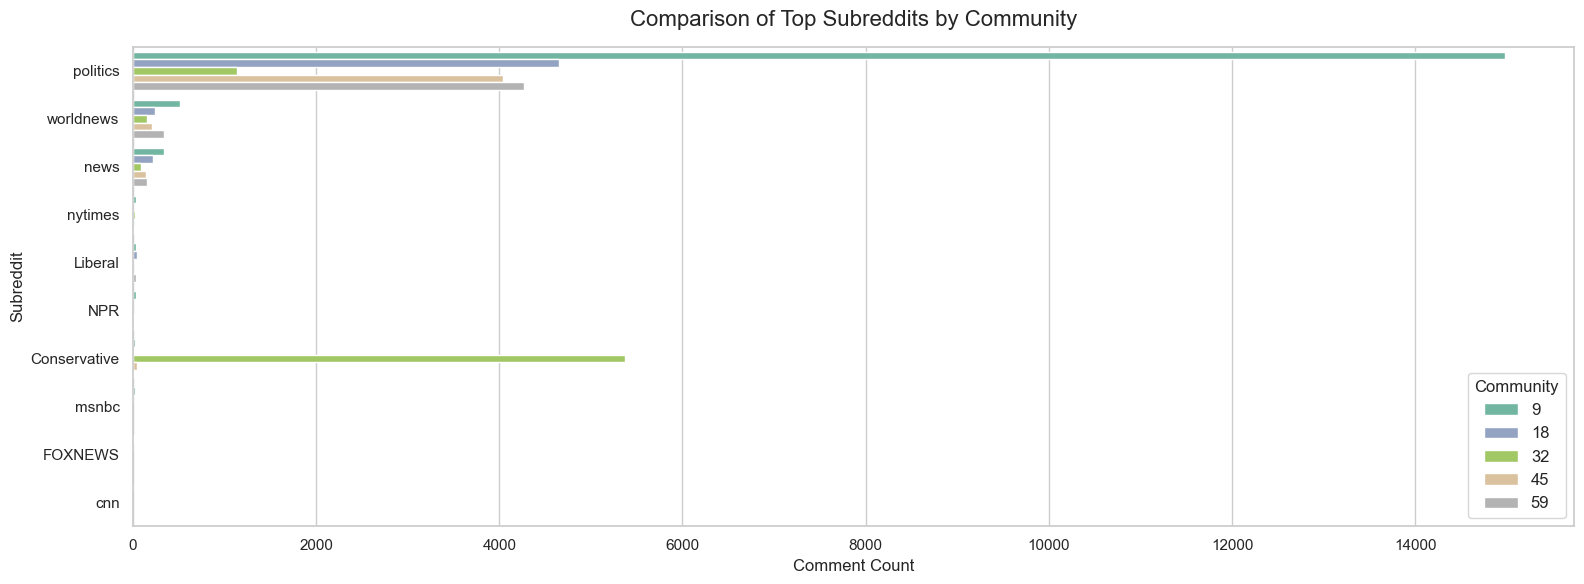

In [45]:
subreddit_counts = (
    top_5_comments_df
    .groupby(['community_id', 'subreddit'])
    .size()
    .reset_index(name='comment_count')
)
N = 15
top_subreddits_per_community = subreddit_counts.groupby('community_id').apply(
    lambda x: x.nlargest(N, 'comment_count')
).reset_index(drop=True)

combined_data = top_subreddits_per_community[['community_id', 'subreddit', 'comment_count']]
plt.figure(figsize=(16, 6))
sns.barplot(
    data=combined_data,
    x='comment_count',
    y='subreddit',
    hue='community_id',
    palette=color_map
)
plt.title('Comparison of Top Subreddits by Community', fontsize=16, pad=15)
plt.xlabel('Comment Count', fontsize=12)
plt.ylabel('Subreddit', fontsize=12)
plt.legend(title="Community", fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()


In [46]:
distribution_table_data = top_subreddits_per_community.pivot(
    index="subreddit", columns="community_id", values="comment_count"
).fillna(0).astype(int)
distribution_table_data = distribution_table_data.applymap(lambda x: f"{x:,}".replace(",", "."))
distribution_columns = ["Subreddit"] + [f"Community {col}" for col in distribution_table_data.columns]
distribution_rows = distribution_table_data.reset_index().values.tolist()

create_table_markdown(
    distribution_columns,
    rows=distribution_rows,
    table_title="Distribution of comments in subreddits across the top 5 communities"
)


C:\Users\willi\AppData\Local\Temp\ipykernel_29436\1392308185.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  distribution_table_data = distribution_table_data.applymap(lambda x: f"{x:,}".replace(",", "."))


### Distribution of comments in subreddits across the top 5 communities
| Subreddit | Community 9 | Community 18 | Community 32 | Community 45 | Community 59 |
| --------- | ----------- | ------------ | ------------ | ------------ | ------------ |
| Conservative | 24 | 10 | 5.372 | 50 | 7 |
| FOXNEWS | 13 | 3 | 0 | 0 | 0 |
| Liberal | 37 | 43 | 3 | 3 | 31 |
| NPR | 31 | 6 | 3 | 11 | 17 |
| cnn | 1 | 0 | 0 | 0 | 0 |
| msnbc | 18 | 1 | 0 | 0 | 0 |
| news | 335 | 219 | 89 | 145 | 151 |
| nytimes | 39 | 6 | 23 | 4 | 10 |
| politics | 14.984 | 4.650 | 1.142 | 4.041 | 4.266 |
| worldnews | 510 | 245 | 159 | 210 | 341 |


Again, we see that Community 32 is dominant in Conservative while also having a significant number of comments in Politics. Community 9 has the highest count in Politics but relatively low numbers in most other subreddits compared to its size. Communities 18, 45, and 50 have high numbers in Politics and lower numbers in News and WorldNews, but based on their sizes, they are better represented in News and WorldNews than Communities 9 and 32.

To gain insight into each community, we identify some of their most central comments by finding the most replied-to comment from the author with the highest degree in each of the five communities.

In [47]:
author_degrees = dict(G.degree())
for comment in comments_data:
    comment['degree'] = author_degrees.get(comment['author'], 0)

id_to_author = {comment['id']: comment['author'] for comment in comments_data}
comments_df = pd.DataFrame(comments_data)
comments_df['community_id'] = comments_df['author'].map(partition)
comments_df = comments_df[comments_df['community_id'].notnull()]
comments_df['community_id'] = comments_df['community_id'].astype(int)

top_comments = []
for community_id, group in comments_df[comments_df['community_id'].isin(top_5_ids)].groupby('community_id'):
    top_author = group.loc[group['degree'].idxmax()]['author']
    top_author_comments = group[group['author'] == top_author]
    comment_link_counts = {comment['id']: 0 for _, comment in top_author_comments.iterrows()}
    for comment in comments_data:
        parent_id = comment['parent_id'][3:]
        if parent_id in comment_link_counts:
            comment_link_counts[parent_id] += 1

    most_linked_comment_id = max(comment_link_counts, key=comment_link_counts.get, default=None)
    if most_linked_comment_id:
        most_linked_comment = top_author_comments[top_author_comments['id'] == most_linked_comment_id].iloc[0]
        top_comments.append({
            "Community ID": community_id,
            "Author": top_author,
            "Degree": int(most_linked_comment['degree']),
            "Top Comment": most_linked_comment['body'],
            "Date" : datetime.utcfromtimestamp(most_linked_comment['created_utc']).strftime('%Y-%m-%d')
        })

def clean_for_markdown(text):
    return re.sub(r"[\r\n\\]+", " ", re.sub(r"([`*_{}[\]()#+\-.!])", r"\\\1", text))

max_chars = 200
for comment in top_comments:
    comment['Top Comment'] = clean_for_markdown(comment['Top Comment'][:max_chars] + '...'
                                                if len(comment['Top Comment']) > max_chars
                                                else comment['Top Comment'])

columns = ["Community ID", "Author", "Degree", "Date", "Top Comment"]
rows = [[comment[col] for col in columns] for comment in top_comments]

top_comments_markdown_table = create_table_markdown(
    columns,
    rows=rows,
    table_title="Top comments by most users with highest degree in each community"
)

### Top comments by most users with highest degree in each community
| Community ID | Author | Degree | Date | Top Comment |
| ------------ | ------ | ------ | ---- | ----------- |
| 9 | TintedApostle | 152 | 2024-11-08 | The flight of the intellectuals has started . |
| 18 | ljjjkk | 87 | 2024-11-05 | Only 13 Presidents failed to get re -elected . Only 5 Presidents failed to win the popular vote . Only 4 Presidents have been impeached or resigned . Only 1 President has ever been criminally convicted . . . |
| 32 | TwilightSolitude | 63 | 2024-11-06 | r/politics in shambles |
| 45 | JWBeyond1 | 150 | 2024-11-06 | Just wait till the tariffs kick in |
| 59 | TurboSalsa | 233 | 2024-11-07 | We can hem and haw over messaging and candidate quality but the bottom line is that a large chunk of "median voters" appears to have voted for a guy whose policies they didn't understand because they  . . . |


We see that Community 32's top comment mocks the left-leaning subreddit Politics after the election. Communities 45 and 59 mock Trump voters, implying they don't understand the politics they supported. Community 18 mocks Trump for being a convicted felon, and Community 9 comments on a Telegraph article titled 'Left-wing millionaires flee America over Trump’s victory' and describes the left-wings as intellectuals. Emotions are running high across all communities.

## 6. Force-directed visualization of the network

For better visualization, we focus only on the nodes in the top five communities with an edge degree larger than 1.

In [48]:
G_top_5 = G.copy()

for node in list(G_top_5.nodes):
    if partition[node] not in dict(top_5_communities):
        G_top_5.remove_node(node)

print("Number of nodes in the top 5 communities:", G_top_5.number_of_nodes())

nodes_to_remove = [node for node, degree in dict(G_top_5.degree()).items() if degree < 2]
G_top_5.remove_nodes_from(nodes_to_remove)

largest_component = max(nx.connected_components(G_top_5), key=len)
G_top_5 = G_top_5.subgraph(largest_component).copy()

print("Number of nodes in the top 5 communities after modifications:", G_top_5.number_of_nodes())

Number of nodes in the top 5 communities: 14701
Number of nodes in the top 5 communities after modifications: 5824


We use forceatlas2 to spread out the nodes based on their connections

In [49]:
pickle_file = os.path.join(directory, "forceatlas2_positions.pkl")
version = 8
cached_positions = load_cached_data([version], pickle_file)
if not cached_positions:
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,
        verbose=True,
        scalingRatio=0.000001,
        strongGravityMode=False,
        gravity=0.0004,
    )
    positions = forceatlas2.forceatlas2_networkx_layout(G_top_5, pos=None, iterations=100)
    save_cached_data([version], positions, pickle_file)
else:
    positions = cached_positions

Using cached data.


c:\Users\willi\OneDrive\Dokumenter\GitHub\dtu-02805-project\.venv\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


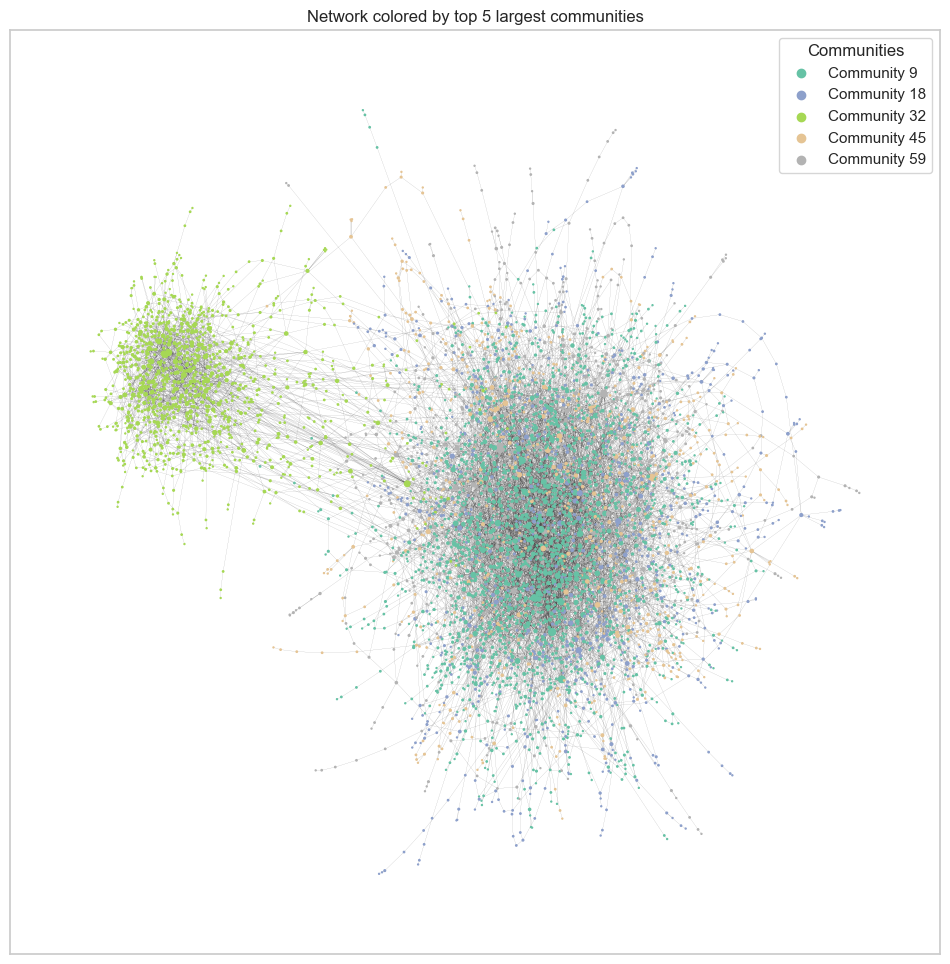

In [50]:
node_colors = [
    color_map.get(partition[node], 'black') for node in G_top_5.nodes()
]

plt.figure(figsize=(12, 12))
ax = plt.gca()

nx.draw_networkx(
    G_top_5,
    pos=positions,
    with_labels=False,
    node_color=node_colors,
    node_size=[G_top_5.degree(node) / 2 for node in G_top_5.nodes()],
    cmap=plt.get_cmap('tab10'),
    font_size=6,
    font_color="black",
    arrows=False,
    width=0.05
)

for community, color in color_map.items():
    plt.scatter([], [], color=color, label=f"Community {community}")

plt.legend(title="Communities", loc="upper right")
plt.title("Network colored by top 5 largest communities")
plt.grid(False)
plt.show()

We see that Communities 9, 18, 45 and 59 have significant overlap and cluster together on the right, while Community 32 is more isolated on the left, indicating a lack of interactions between the pro-Trump Community 32 and the pro-Harris Communities 9, 18, 45 and 59.

## 7. TF-IDF and PCA analysis

We compute the TF-IDF scores for the words in the comments, where each document represents all the comments in a community, and plot the first two principal components of a PCA analysis.

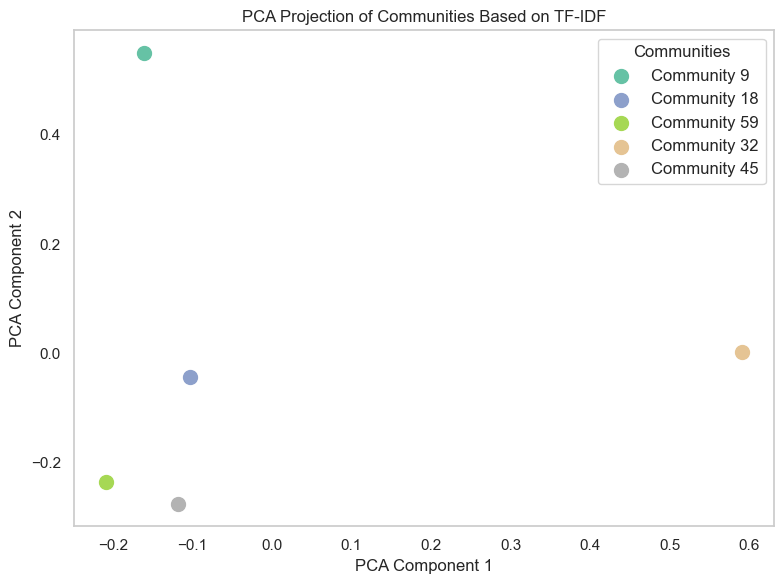

Variance explained by the two components: [0.26496566 0.26007813]


In [51]:
documents = {
    community_id: ' '.join(
        [comment['body'] for comment in comments_data 
         if comment['author'] in partition and partition[comment['author']] == community_id]
    ) 
    for community_id in top_5_ids
}

vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=False, sublinear_tf=True)
tfidf_matrix = vectorizer.fit_transform(documents.values())
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=documents.keys(), columns=vectorizer.get_feature_names_out())

num_communities = len(top_5_ids)
color_map = {community_id: get_community_color(idx, num_communities) for idx, community_id in enumerate(top_5_ids)}
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_df)

plt.figure(figsize=(8, 6))
for i, community_id in enumerate(top_5_ids):
    plt.scatter(
        reduced_data[i, 0], 
        reduced_data[i, 1], 
        label=f"Community {community_id}", 
        s=100, 
        color=color_map.get(community_id, 'black') 
    )
plt.title("PCA Projection of Communities Based on TF-IDF")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Communities", fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

print("Variance explained by the two components:", pca.explained_variance_ratio_)

We see that Communities 18, 45 and 59 cluster together in the lower-left corner, while Community 32 scores high on the first principal component and Community 9 scores high on the second principal component. The variance explained by the two principal components is approximately 26% each, and the distance from the small cluster to Communities 9 and 32 is about the same. This indicates that not only does the right-leaning Community 32 differ from the others, but so does Community 9, possibly by the same amount. While I would have liked to explain this using the loadings, the large number of terms made it unfeasible. Based on previous insights about comments and distribution across subreddits, I lean toward the idea that Communities 9, 18, 45, and 58 are all left leaning, with Community 9 likely being more US-based and the others more globally oriented.

## 8. The defining term of the day 

To visualize the day-by-day "mood" in each community, we create a document for each day and each community, compute the TF-IDF scores, and amplify it using NLTK's sentiment analyzer.

In [52]:
# we define preprocess_text to lowercase, remove punctuation, digits, extra spaces from the comments/documents
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# we define lemmatize_terms to lemmatize the terms in the the comments/documents.
lemmatizer = WordNetLemmatizer()
def lemmatize_terms(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# we create a document with all comments for each day and community
analyzer = SentimentIntensityAnalyzer()
daily_documents = defaultdict(str)
for comment in comments_data:
    author = comment['author']
    community_id = partition.get(author)
    if community_id in top_5_ids:
        date = datetime.utcfromtimestamp(comment['created_utc']).date()
        if start_date.date() <= date <= end_date.date():
            if community_id in [18, 45, 59]:
                community_id = "18_45_59"
            daily_documents[(date, community_id)] += f" {preprocess_text(comment['body'])}"

days = sorted({key[0] for key in daily_documents.keys()})
documents = []
labels = []
for day in days:
    for community_id in set([key[1] for key in daily_documents.keys()]):
        documents.append(lemmatize_terms(preprocess_text(daily_documents.get((day, community_id), ""))))
        labels.append((day, community_id))


custom_stop_words = list(ENGLISH_STOP_WORDS) + ['theyll', 'mods', 'im', 'boy', 'little', 'yes', 'hell', 'win', 'god', 'grand', 'walker']
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df=8, max_df=0.55, sublinear_tf=True, ngram_range=(1, 3))
tfidf_matrix = vectorizer.fit_transform(documents)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.index = pd.MultiIndex.from_tuples(labels, names=["day", "community_id"])

results = {}
for community_id in set(tfidf_df.index.get_level_values("community_id")):
    community_data = tfidf_df.xs(community_id, level="community_id")
    results[community_id] = {}
    for day in community_data.index:
        day_data = community_data.loc[day]

        boosted_scores = {}
        for term in day_data.index:
            sentiment = analyzer.polarity_scores(term)['compound']
            abs_sentiment = abs(sentiment)
            boosted_scores[term] = day_data[term] * (1 + abs_sentiment)
        
        boosted_series = pd.Series(boosted_scores)
        top_terms = boosted_series.nlargest(10)
        results[community_id][day] = top_terms

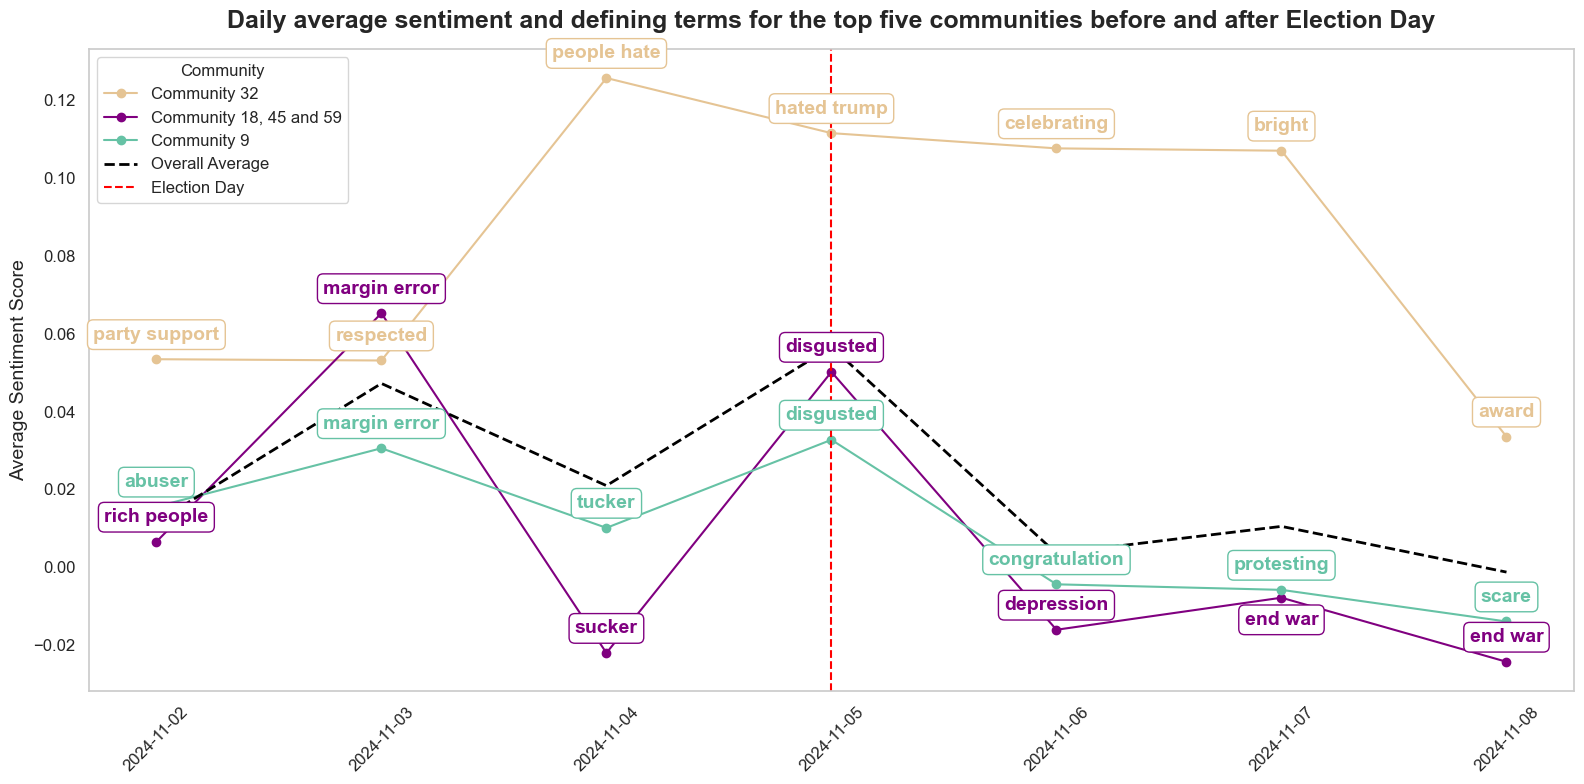

In [53]:
font_size = 14
plt.figure(figsize=(16, 8))

for community_id in results.keys():
    if community_id == "18_45_59":
        combined_sentiments = []
        for sub_id in [18, 45, 59]:
            if sub_id in community_sentiments_cached:
                combined_sentiments.extend(community_sentiments_cached[sub_id])
        
        if combined_sentiments:
            df_grouped = pd.DataFrame(combined_sentiments)
            daily_sentiment_grouped = df_grouped.groupby('date')['sentiment'].mean().reset_index()
            community_color = color_map.get("18_45_59", 'purple')
            
            plt.plot(daily_sentiment_grouped['date'], daily_sentiment_grouped['sentiment'],
                     marker='o', label="Community 18, 45 and 59", color=community_color)
            for day, sentiment_value in zip(daily_sentiment_grouped['date'], daily_sentiment_grouped['sentiment']):
                if day in results["18_45_59"]:
                    top_terms = results["18_45_59"][day]
                    if isinstance(top_terms, pd.Series) and not top_terms.empty:
                        top_term = top_terms.index[0]
                        offset = -0.008 if str(day) == '2024-11-07' else 0.004
                        plt.text(
                            pd.Timestamp(day), sentiment_value + offset, f'{top_term}',
                            color=community_color, fontsize=font_size, ha='center', va='bottom', weight='bold',
                            bbox=dict(facecolor='white', edgecolor=community_color, boxstyle='round,pad=0.3')
                        )
    else:
        if community_id in community_sentiments_cached:
            df_community = pd.DataFrame(community_sentiments_cached[community_id])
            daily_sentiment_community = df_community.groupby('date')['sentiment'].mean().reset_index()
            community_color = color_map.get(community_id, 'blue')
            
            plt.plot(daily_sentiment_community['date'], daily_sentiment_community['sentiment'],
                     marker='o', label=f"Community {community_id}", color=community_color)

            for day, sentiment_value in zip(daily_sentiment_community['date'], daily_sentiment_community['sentiment']):
                if day in results[community_id]:
                    top_terms = results[community_id][day]
                    if isinstance(top_terms, pd.Series) and not top_terms.empty:
                        top_term = top_terms.index[0]
                        plt.text(
                            pd.Timestamp(day), sentiment_value + 0.004, f'{top_term}',
                            color=community_color, fontsize=font_size, ha='center', va='bottom', weight='bold',
                            bbox=dict(facecolor='white', edgecolor=community_color, boxstyle='round,pad=0.3')
                        )

plt.plot(daily_sentiment['date'], daily_sentiment['sentiment'], color='black', linewidth=2, label="Overall Average", linestyle='--')
plt.axvline(x=election_date, color='red', linestyle='--', linewidth=1.5, label="Election Day")
plt.title("Daily average sentiment and defining terms for the top five communities before and after Election Day", fontsize=18, pad=15, weight='bold')
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.legend(title="Community", fontsize=12)
plt.tight_layout()
plt.show()